In [1]:
setwd('E:/notebook/miMatch')
library(plyr) 
library(ggplot2)
library(ggpubr)
library(tidyverse)
library(dplyr)
library(reshape2)
library(VennDiagram)
library(RColorBrewer)
library(pheatmap)
library(repr)
library(readxl)
library(xlsx)


Attaching package: 'ggpubr'


The following object is masked from 'package:plyr':

    mutate


Warning message:
"package 'dplyr' was built under R version 4.3.2"
Warning message:
"package 'stringr' was built under R version 4.3.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::desc()      masks plyr::desc()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks ggpubr::mutate(), plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::su

## Figure 5I Venn

In [2]:
label<-read.csv("Label/project.csv")
path = "E:/notebook/miMatch/Temp"
microdata<-read.csv("Label/IBD/IBDmicrodata.csv",row.names = 1,stringsAsFactors = F)
PSMlabel<-read.csv("Label/IBD/IBDMatchedLabel.csv",stringsAsFactors = F)  
head(microdata)
head(PSMlabel)

,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Faecalibacterium.s__Faecalibacterium_prausnitzii,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_uniformis,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Roseburia.s__Roseburia_hominis,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Rikenellaceae.g__Alistipes.s__Alistipes_putredinis,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Lachnospiraceae_unclassified.s__Eubacterium_rectale,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_dorei,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Fusicatenibacter.s__Fusicatenibacter_saccharivorans,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Blautia.s__Ruminococcus_gnavus,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Agathobaculum.s__Agathobaculum_butyriciproducens,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Dorea.s__Dorea_longicatena,⋯,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Peptostreptococcaceae.g__Paraclostridium.s__Paraclostridium_bifermentans,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Enterococcaceae.g__Vagococcus.s__Vagococcus_lutrae,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Enterococcaceae.g__Enterococcus.s__Enterococcus_cecorum,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales.f__Enterobacteriaceae.g__Citrobacter.s__Citrobacter_sp_MGH106,k__Bacteria.p__Firmicutes.c__Tissierellia.o__Tissierellales.f__Peptoniphilaceae.g__Peptoniphilus.s__Peptoniphilus_grossensis,k__Bacteria.p__Tenericutes.c__Mollicutes.o__Mycoplasmatales.f__Mycoplasmataceae.g__Mycoplasma.s__Mycoplasma_hominis,k__Bacteria.p__Fusobacteria.c__Fusobacteriia.o__Fusobacteriales.f__Fusobacteriaceae.g__Fusobacterium.s__Fusobacterium_hwasookii,k__Bacteria.p__Firmicutes.c__Tissierellia.o__Tissierellales.f__Peptoniphilaceae.g__Peptoniphilus.s__Peptoniphilus_sp_DNF00840,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.s__Streptococcus_sp_HMSC034E03,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales.f__Enterobacteriaceae.g__Citrobacter.s__Citrobacter_gillenii
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SKST006_6_G102964,0,0,0,0,0,0,0,0,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SKST006_7_G102965,0,0,0,0,0,0,0,0,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SKST006_4_G102962,0,0,0,0,0,0,0,0,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SKST006_5_G102963,0,0,0,0,0,0,0,0,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SKST006_2_G102960,0,0,0,0,0,0,0,0,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SKST006_3_G102961,0,0,0,0,0,0,0,0,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,Case,Control
,<chr>,<chr>
1,SKST006_6_G102964,SKST007_6_G102995
2,SKST006_6_G102964,SKST010_1_G102968
3,SKST006_6_G102964,SKST041_3_G103028
4,SKST006_7_G102965,SKST037_2_G103023
5,SKST006_7_G102965,p9223_mo6
6,SKST006_7_G102965,p9281_mo5


In [3]:
#-----unmatched diff taxa p<0.05---------#
microdata$Group<-factor(microdata$Group)
Allum<-ddply(melt(microdata),"variable",
             function(x) {
               w <- wilcox.test(value~Group,data=x)
               with(w,data.frame(statistic,p.value))
             })
colnames(Allum)<-c("variable", "unmatched_statistic", "unmatched_p.value" )

Using Group as id variables



In [6]:
#-----matched diff taxa p<0.05---------#
microdata$sample_id<-rownames(microdata)
matched<-data.frame(sample_id=c(PSMlabel$Case,PSMlabel$Control)) 

matched<-join(matched,microdata,match="first")
matched$Group<-factor(matched$Group)
Allm<-ddply(melt(matched[,-1]),"variable",
            function(x) {
              w <- wilcox.test(value~Group,data=x,paired=T)
              with(w,data.frame(statistic,p.value))
            })
colnames(Allm)<-c("variable", "matched_statistic", "matched_p.value" )

Joining by: sample_id

Using Group as id variables



In [7]:
#-----results-----#
microPResult<-join(Allum,Allm,match="first")

microPResult$Pchange<-microPResult$matched_p.value-microPResult$unmatched_p.value
microPResult<-microPResult[order(abs(microPResult$Pchange),decreasing = T),]

c<-str_split_fixed(microPResult$variable,"c__",2)[,2]
class<-str_split_fixed(c,"[.]",2)[,1]
microPResult$Class=class

s<-str_split_fixed(microPResult$variable,"s__",2)[,2]
species<-str_split_fixed(s,"[.]",2)[,1]
microPResult$Species=species
head(microPResult)

write.csv(microPResult,"./ShowFigures_Results/IBD_wilcox.csv",row.names = F)

Joining by: variable



,variable,unmatched_statistic,unmatched_p.value,matched_statistic,matched_p.value,Pchange,Class,Species
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
18,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_ovatus,619637.0,4.627414e-05,1579355.0,9.917778e-01,0.9917315,Bacteroidia,Bacteroides_ovatus
101,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_stercoris,688287.5,9.874443e-01,1736303.5,1.006753e-07,-0.9874442,Bacteroidia,Bacteroides_stercoris
568,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Lactobacillaceae.g__Lactobacillus.s__Lactobacillus_algidus,433437.5,9.742784e-01,988462.5,1.938222e-04,-0.9740845,Bacilli,Lactobacillus_algidus
385,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales.f__Enterobacteriaceae.g__Citrobacter.s__Citrobacter_werkmanii,634535.0,9.711372e-01,1389352.0,3.935613e-03,-0.9672016,Gammaproteobacteria,Citrobacter_werkmanii
229,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Prevotellaceae.g__Prevotella.s__Prevotella_bivia,688680.5,9.809464e-01,1551837.0,1.993960e-02,-0.9610068,Bacteroidia,Prevotella_bivia
341,k__Bacteria.p__Firmicutes.c__Negativicutes.o__Veillonellales.f__Veillonellaceae.g__Megasphaera.s__Megasphaera_micronuciformis,625422.0,3.478133e-02,1406523.0,9.639497e-01,0.9291684,Negativicutes,Megasphaera_micronuciformis


In [9]:
nrow(microPResult[which(microPResult$unmatched_p.value<0.05),])
nrow(microPResult[which(microPResult$matched_p.value<0.05),])
nrow(microPResult[which(microPResult$matched_p.value<0.05 & microPResult$unmatched_p.value<0.05),])

[1] 350

[1] 436

[1] 319

(polygon[GRID.polygon.1], polygon[GRID.polygon.2], polygon[GRID.polygon.3], polygon[GRID.polygon.4], text[GRID.text.5], text[GRID.text.6], text[GRID.text.7], text[GRID.text.8], text[GRID.text.9]) 

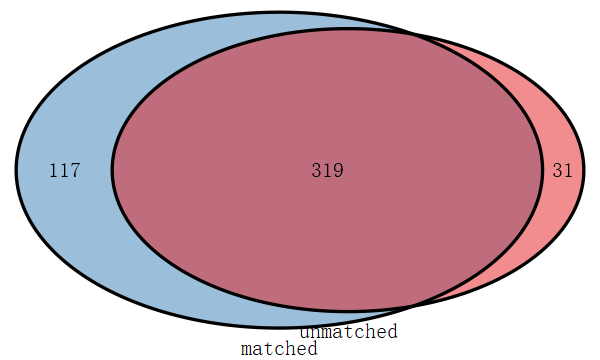

In [10]:
options(repr.plot.width=5,repr.plot.height=3)
draw.pairwise.venn(
  area1 = 350,
  area2 = 436,
  cross.area = 319,
  category = c("unmatched", "matched"),
  fill = brewer.pal(7, "Set1")[1:2],
  cat.pos = c(0, 0)
)

## Figure 5J. heatmap

In [15]:
microPResult=read.csv("./ShowFigures_Results/IBD_wilcox.csv")
PMIDResults=read.csv("./Label/PMIDResults.csv")
head(microPResult)
head(PMIDResults)

,Species,variable,unmatched_statistic,unmatched_p.value,matched_statistic,matched_p.value,Pchange,Class,PMID
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,Bacteroides ovatus,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_ovatus,619637.0,0.00004630,1579355.0,0.991777807,0.9917315,Bacteroidia,17897884
2,Bacteroides stercoris,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_stercoris,688287.5,0.98744431,1736303.5,0.000000101,-0.9874442,Bacteroidia,NA
3,Lactobacillus algidus,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Lactobacillaceae.g__Lactobacillus.s__Lactobacillus_algidus,433437.5,0.97427837,988462.5,0.000193822,-0.9740845,Bacilli,NA
4,Citrobacter werkmanii,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Enterobacterales.f__Enterobacteriaceae.g__Citrobacter.s__Citrobacter_werkmanii,634535.0,0.97113718,1389352.0,0.003935613,-0.9672016,Gammaproteobacteria,NA
5,Prevotella bivia,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Prevotellaceae.g__Prevotella.s__Prevotella_bivia,688680.5,0.98094643,1551837.0,0.019939596,-0.9610068,Bacteroidia,NA
6,Megasphaera micronuciformis,k__Bacteria.p__Firmicutes.c__Negativicutes.o__Veillonellales.f__Veillonellaceae.g__Megasphaera.s__Megasphaera_micronuciformis,625422.0,0.03478133,1406523.0,0.963949695,0.9291684,Negativicutes,31796936


,microbe_scientific_name,tax_rank_name,disease_mesh_heading,publication_PMID
,<chr>,<chr>,<chr>,<chr>
1,Clostridioides difficile,Species,Crohn Disease,20848492; 22529960
2,Roseburia intestinalis,Species,Crohn Disease,22529960
3,Campylobacter gracilis,Species,Crohn Disease,23060013
4,Gemella morbillorum,Species,Crohn Disease,24013298
5,Roseburia intestinalis,Species,Crohn Disease,26789999
6,Intestinibacter bartlettii,Species,Crohn Disease,30519287


In [16]:
difftaxa=PMIDResults$microbe_scientific_name
taxa=microPResult[which(microPResult$Species%in%difftaxa),]
head(taxa)

,Species,variable,unmatched_statistic,unmatched_p.value,matched_statistic,matched_p.value,Pchange,Class,PMID
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
23,Megamonas hypermegale,k__Bacteria.p__Firmicutes.c__Negativicutes.o__Selenomonadales.f__Selenomonadaceae.g__Megamonas.s__Megamonas_hypermegale,635839.0,0.80782334,1435804,0.01551742,-0.7923059,Negativicutes,31796936
28,Bifidobacterium pseudocatenulatum,k__Bacteria.p__Actinobacteria.c__Actinobacteria.o__Bifidobacteriales.f__Bifidobacteriaceae.g__Bifidobacterium.s__Bifidobacterium_pseudocatenulatum,692700.5,0.73905492,1627817,0.03787305,-0.7011819,Actinobacteria,30567928
51,Intestinimonas butyriciproducens,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_unclassified.g__Intestinimonas.s__Intestinimonas_butyriciproducens,664529.0,0.09181799,1566165,0.60835057,0.5165326,Clostridia,30567928
54,Anaerotruncus colihominis,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Anaerotruncus.s__Anaerotruncus_colihominis,678534.0,0.44059423,1582261,0.91398861,0.4733944,Clostridia,30567928
102,Christensenella minuta,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Christensenellaceae.g__Christensenella.s__Christensenella_minuta,694285.0,0.35623228,1602671,0.05353343,-0.3026988,Clostridia,26789999
145,Intestinibacter bartlettii,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Peptostreptococcaceae.g__Intestinibacter.s__Intestinibacter_bartlettii,702351.0,0.32473114,1624069,0.10227604,-0.2224551,Clostridia,30519287


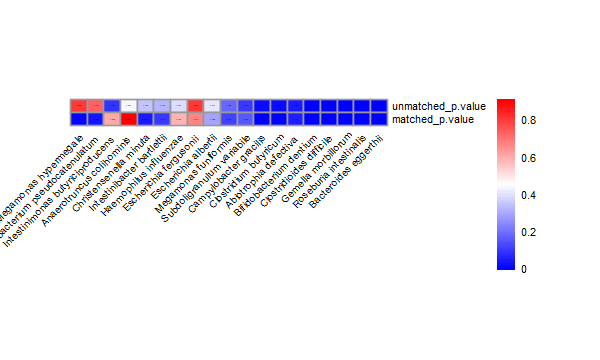

In [17]:
linshi=t(taxa[,c(4,6)])
colnames(linshi)=taxa$Species
red <- rgb(255,0,0,maxColorValue = 255)
blue <- rgb(0,0,255,maxColorValue = 255)
white <- rgb(255,255,255,maxColorValue = 255)
pheatmap(linshi,fontsize=6,cutree_col = 6,cellheight = 8,cellwidth = 10 ,
         color  = colorRampPalette(c(blue,white,red))(100),
         clustering_method = "ward.D2",display_numbers=T,
         number_format = "%.3f",number_color = "black",
         fontsize_number = 0.6,
         border_color = "grey60",angle_col = 45,
         cluster_cols = F, cluster_rows = F,
         show_rownames = T, show_colnames = T
)
